# 画像生成 AI 入門: Python による拡散モデルの理論と実践

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shunk031/coloso-python-diffusion-models/blob/main/lectures/section-07-25.ipynb)

## Section 07. Play with Diffusion Model

Stable Diffusion を中心とした拡散モデルを用いて、最先端の画像生成技術を実際に動かして実践していきます。

### Lecture 25. InstructPix2Pix

InstructPix2Pix [[Brooks+ CVPR'23]](https://arxiv.org/abs/2211.09800) を用いて、テキストプロンプトにのみによる画像編集を実現します。

## セットアップ

### GPU が使用できるか確認

本 Colab ノートブックを実行するために GPU ランタイムを使用していることを確認します。CPU ランタイムと比べて画像生成がより早くなります。以下の `nvidia-smi` コマンドが失敗する場合は再度講義資料の `GPU 使用設定` のスライド説明や Google Colab の [FAQ](https://research.google.com/colaboratory/faq.html#gpu-utilization) 等を参考にランタイムタイプが正しく変更されているか確認してください。

In [ ]:
!nvidia-smi

Wed Jul 19 13:53:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 利用する Python ライブラリをインストール

diffusers ライブラリをインストールすることで拡散モデルを簡単に使用できるようにします。diffusers ライブラリを動かす上で必要となるライブラリも追加でインストールします:
- [transformers](https://github.com/huggingface/transformers): 拡散モデルにおいて核となる Transformer モデルが定義されているライブラリ
- [accelerate](https://github.com/huggingface/accelerate): transformers と連携してより高速な画像生成をサポートするライブラリ

In [ ]:
!pip install diffusers==0.16.1
!pip install transformers accelerate

## InstructPix2Pix を扱うパイプラインを構築

本セクションでは [`StableDiffusionInstructPix2PixPipeline`](https://huggingface.co/docs/diffusers/api/pipelines/pix2pix) を使用して InstructPix2Pix パイプラインの動作を確認します。

以下、[InstructPix2Pix: Learning to Follow Image Editing Instructions](https://github.com/huggingface/notebooks/blob/main/diffusers/InstructPix2Pix_using_diffusers.ipynb) を参考に、InstructPix2Pix の動作を追っていきます。

InstructPix2Pix は Stable Diffusion をベースにテキストで画像編集の指示が出せるモデルです。

まず準備として画像を複数生成した場合に結果を確認しやすいように、画像をグリッド上に表示する関数を以下のように定義します。この関数は [🤗 Hugging Face Stable Diffusion](https://huggingface.co/blog/stable_diffusion) のブログ記事のものを利用しています。

In [ ]:
from typing import List
from PIL import Image
from PIL.Image import Image as PilImage

def image_grid(imgs: List[PilImage], rows: int, cols: int) -> PilImage:
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

今回使用するサンプル画像を InstructPix2Pix の著者のレポジトリからダウンロードしてきます。以下ではミケランジェロのダビデ像の画像を使用します。

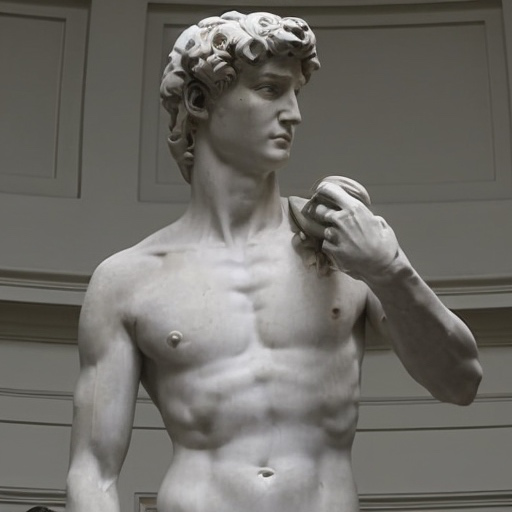

In [ ]:
from diffusers.utils import load_image

original_image = load_image("https://raw.githubusercontent.com/timothybrooks/instruct-pix2pix/main/imgs/example.jpg")
original_image

InstructPix2Pix が使えるように `StableDiffusionInstructPix2PixPipeline` で学習済みパラメータである `timbrooks/instruct-pix2pix` を読み込みます。



In [ ]:
import torch
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler

model_id = "timbrooks/instruct-pix2pix"
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    revision="fp16",
    safety_checker=None, # NSFW 用のフィルターを今回は使わないようにします
)
pipe = pipe.to("cuda")

# attention 計算の最適化を実施
pipe.enable_attention_slicing()

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_instruct_pix2pix.StableDiffusionInstructPix2PixPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


InstructPix2Pix の論文でも紹介されているプロンプト `turn him into cyborg` を試してみます。オリジナルの画像とその編集指示プロンプトをパイプラインに入力することで、指示した通りのスタイルへと画像を編集します。

ここで `image_guidance_scale` はオリジナル画像をどれだけ反映するかのパラメータです。大きければ大きいほどオリジナル画像に近い画像が生成されます

  0%|          | 0/30 [00:00<?, ?it/s]

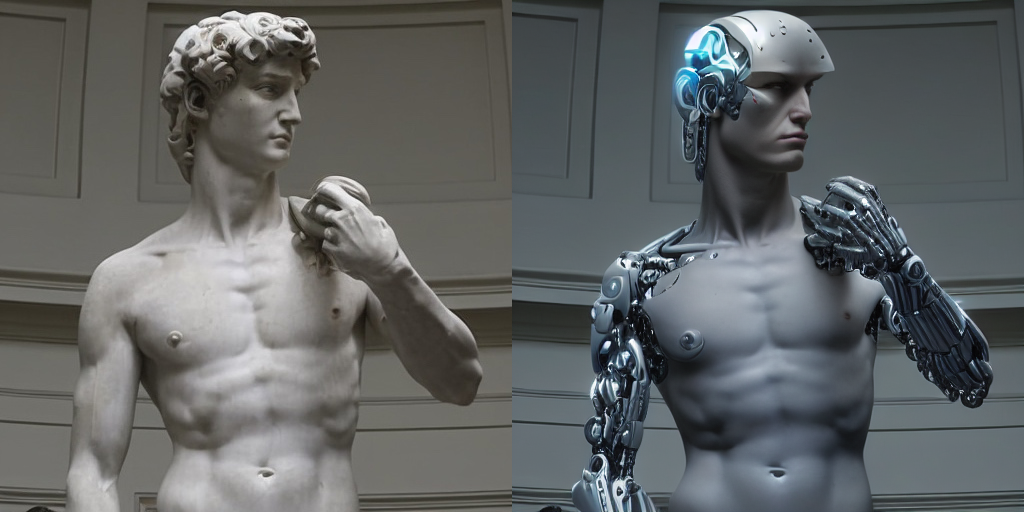

In [ ]:
edit_instruction = "turn him into cyborg"

generator = torch.Generator().manual_seed(19950815)

edited_image = pipe(
    prompt=edit_instruction,
    image=original_image,
    generator=generator,
    num_inference_steps=30,
    image_guidance_scale=1,
).images[0]

image_grid([original_image, edited_image], rows=1, cols=2)

編集指示テキストの強さ `s_T` と オリジナル画像の強さ `s_I` をそれぞれ変化させたときに生成される画像を比較してみましょう。パイプラインの呼び出しを簡略化する以下の関数を使って比較してみます。

In [ ]:
def generate_image(s_T: float, s_I: float) -> PilImage:
    generator = torch.Generator().manual_seed(19950815)

    return pipe(
        prompt=edit_instruction,
        image=original_image,
        generator=generator,
        num_inference_steps=30,
        guidance_scale=s_T,
        image_guidance_scale=s_I
    ).images[0]

`s_T` と `s_I` をそれぞれ変化させて、画像を生成させてみます。

In [ ]:
import itertools

s_T_list = [3, 7.5, 15]
s_I_list = [1.0, 1.2, 1.6]
combinations = list(itertools.product(s_I_list, s_T_list))

images = []
for (s_I, s_T) in combinations:
    print(f"Generate image with s_T = {s_T} and s_I = {s_I}")
    images.append(generate_image(s_T=s_T, s_I=s_I))

Generate image with s_T = 3 and s_I = 1.0


  0%|          | 0/30 [00:00<?, ?it/s]

Generate image with s_T = 7.5 and s_I = 1.0


  0%|          | 0/30 [00:00<?, ?it/s]

Generate image with s_T = 15 and s_I = 1.0


  0%|          | 0/30 [00:00<?, ?it/s]

Generate image with s_T = 3 and s_I = 1.2


  0%|          | 0/30 [00:00<?, ?it/s]

Generate image with s_T = 7.5 and s_I = 1.2


  0%|          | 0/30 [00:00<?, ?it/s]

Generate image with s_T = 15 and s_I = 1.2


  0%|          | 0/30 [00:00<?, ?it/s]

Generate image with s_T = 3 and s_I = 1.6


  0%|          | 0/30 [00:00<?, ?it/s]

Generate image with s_T = 7.5 and s_I = 1.6


  0%|          | 0/30 [00:00<?, ?it/s]

Generate image with s_T = 15 and s_I = 1.6


  0%|          | 0/30 [00:00<?, ?it/s]

生成結果について確認します。

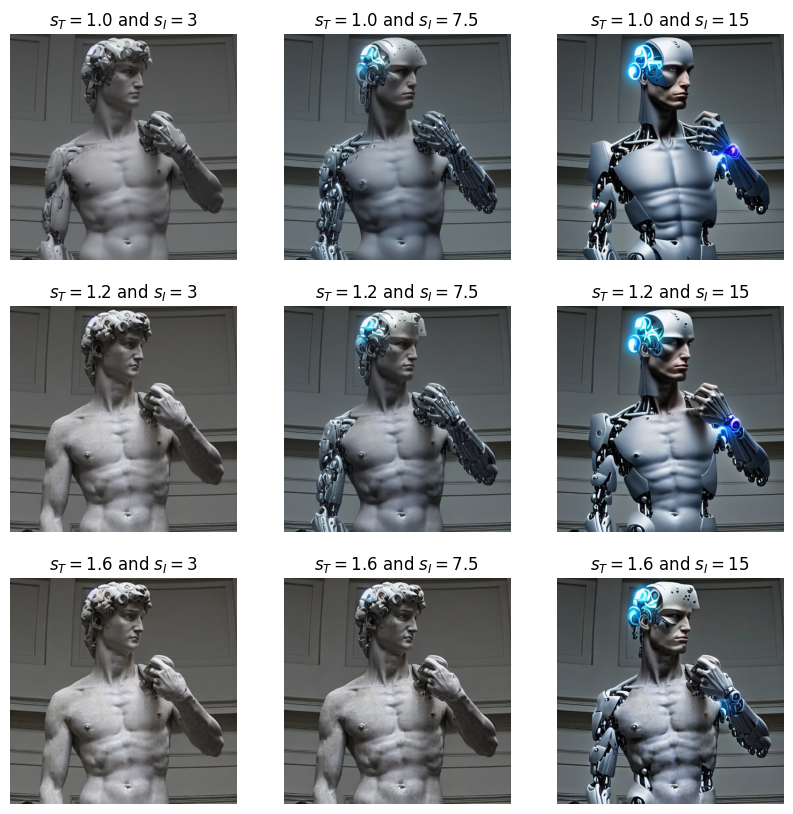

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))

for i, ((s_T, s_I), image) in enumerate(zip(combinations, images)):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(image)
    ax.set_title(f"$s_T = {s_T}$ and $s_I = {s_I}$")
    ax.axis("off")
plt.show()

- 横方向で見ると: 左から右へ、指示テキストの影響が強くなっていく
- 縦方向で見ると: 上から下へ、オリジナル画像の影響が強くなっていく